
http://help.simplecv.org/question/228/gaze-tracking-possible/
http://www.diku.dk/hjemmesider/ansatte/panic/eyegaze/node9.html#SECTION00061000000000000000

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
np.set_printoptions(precision=2, suppress=True)
# define plots to be inserted interactively
import matplotlib.pyplot as plt
%matplotlib inline
import cv2


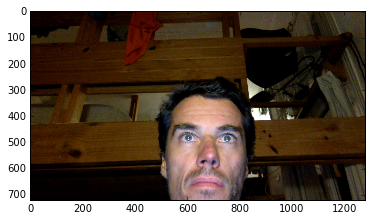

In [2]:
from LeCheapEyeTracker import Camera
cam = Camera()
frame = cam.run(T=1)
cam.close()
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

FPS :  10.475136892989552


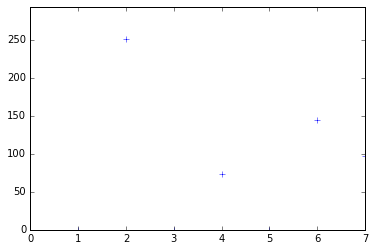

In [3]:
plt.plot(np.diff(np.array(cam.ctime))*1000, '+')
_ = plt.axis('tight')
print ('FPS : ',  cam.N/(cam.ctime[-1]-cam.ctime[0]))

(720, 1280, 3) 0 255


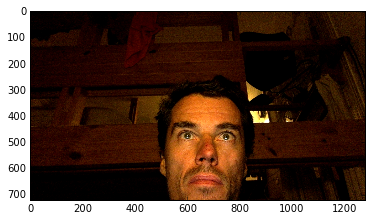

In [4]:
cam = Camera()
img = cam.grab()
img = cam.grab()
cam.close()
print(img.shape, img.min(), img.max())
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

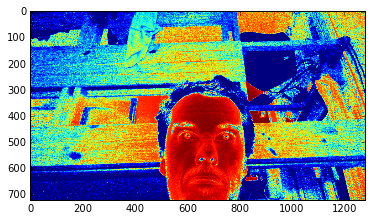

In [5]:
img_ = img.copy()
gray = cv2.cvtColor(img_, cv2.COLOR_BGR2GRAY)
gray = cv2.equalizeHist(gray)

plt.imshow(gray)

Parameters:	

        cascade – Haar classifier cascade (OpenCV 1.x API only). It can be loaded from XML or YAML file using Load(). When the cascade is not needed anymore, release it using cvReleaseHaarClassifierCascade(&cascade).
        image – Matrix of the type CV_8U containing an image where objects are detected.
        objects – Vector of rectangles where each rectangle contains the detected object.
        scaleFactor – Parameter specifying how much the image size is reduced at each image scale.
        minNeighbors – Parameter specifying how many neighbors each candidate rectangle should have to retain it.
        flags – Parameter with the same meaning for an old cascade as in the function cvHaarDetectObjects. It is not used for a new cascade.
        minSize – Minimum possible object size. Objects smaller than that are ignored.
        maxSize – Maximum possible object size. Objects larger than that are ignored.



205 110 85 85
59 109 76 76


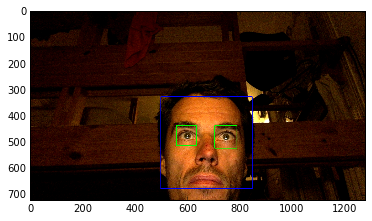

In [6]:
import cv2

face_cascade = cv2.CascadeClassifier('/Users/laurentperrinet/pool/libs/vision/opencv/data/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('/Users/laurentperrinet/pool/libs/vision/opencv/data/haarcascades/haarcascade_eye.xml')

img_ = img.copy()
out = img.copy()
faces = face_cascade.detectMultiScale(img_, 1.3, 5) # image[, scaleFactor[, minNeighbors[, flags[, minSize[, maxSize]
eyelist = []
for (x,y,w,h) in faces:
    img_ = cv2.rectangle(img_, (x,y), (x+w,y+h), (255,0,0), 2)
    roi_color = img_[y:y+h, x:x+w]
    out_color = out[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_color, 1.1, 5, 4)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color, (ex,ey), (ex+ew,ey+eh), (0,255,0), 2)
        eyelist.append(out_color[ey:ey+eh, ex:ex+ew])
        print(ex,ey,ew,eh)
plt.imshow(cv2.cvtColor(img_, cv2.COLOR_BGR2RGB))

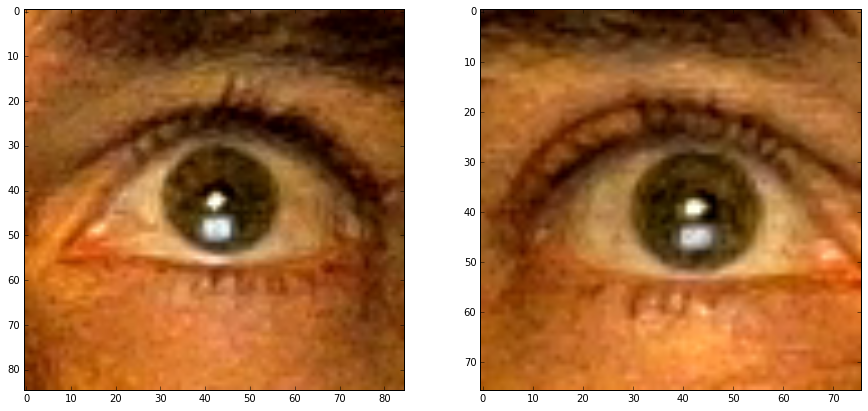

In [17]:
fig, axs = plt.subplots(1, len(eyelist), figsize=(15, 7.5))
for i, eye in enumerate(eyelist):
    axs[i].imshow(cv2.cvtColor(eye, cv2.COLOR_BGR2RGB))

TODO : set minNeighbors then increase until we have one face only - same for eyes see http://stackoverflow.com/questions/22249579/opencv-detectmultiscale-minneighbors-parameter

##  segmenting the different parts

- the eyebrow on upper quarter 
- the skin is all around
- the reflection is white and small
- the iris is round, darker


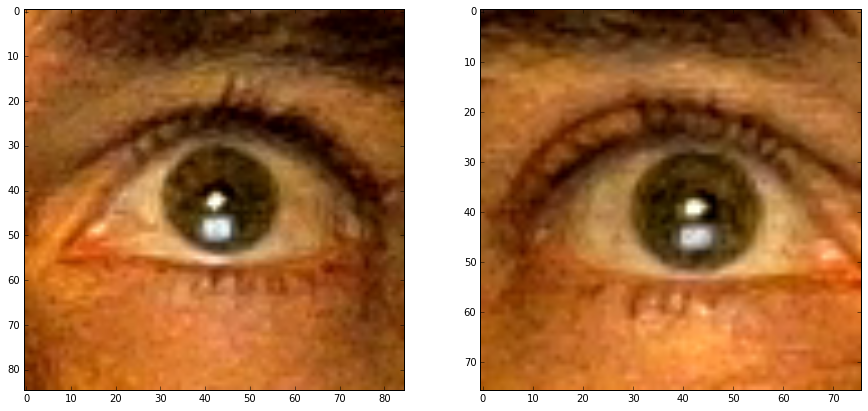

In [16]:
fig, axs = plt.subplots(1, len(eyelist), figsize=(15, 7.5))
for i, eye in enumerate(eyelist):
    axs[i].imshow(cv2.cvtColor(eye, cv2.COLOR_BGR2RGB))

In [9]:
def otsu_thresh(hist):
    # find normalized_histogram, and its cumulative distribution function
    hist_norm = hist.ravel()/hist.max()
    Q = hist_norm.cumsum()

    bins = np.arange(256)

    fn_min = np.inf
    thresh = -1

    for i in range(1, 256):
        p1,p2 = np.hsplit(hist_norm,[i]) # probabilities
        q1,q2 = Q[i],Q[255]-Q[i] # cum sum of classes
        b1,b2 = np.hsplit(bins,[i]) # weights

        # finding means and variances
        m1,m2 = np.sum(p1*b1)/q1, np.sum(p2*b2)/q2
        v1,v2 = np.sum(((b1-m1)**2)*p1)/q1,np.sum(((b2-m2)**2)*p2)/q2

        # calculates the minimization function
        fn = v1*q1 + v2*q2
        if fn < fn_min:
            fn_min = fn
            thresh = i
    return thresh


### eyebrow

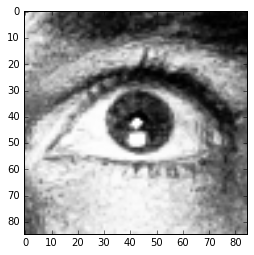

In [10]:
gray = cv2.cvtColor(eyelist[0],cv2.COLOR_BGR2GRAY)
gray = cv2.equalizeHist(gray)
plt.imshow(gray, cmap = plt.cm.Greys_r)

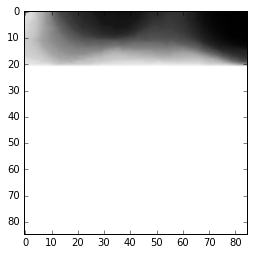

In [11]:
eyebrow = gray.copy()
eyebrow[(eyebrow.shape[0]//4):, :] = eyebrow.max()
#gray = cv2.equalizeHist(gray)
eyebrow = cv2.medianBlur(eyebrow, 19)

plt.imshow(eyebrow, cmap = plt.cm.Greys_r)

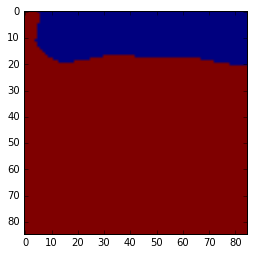

In [12]:
ret, eyebrow = cv2.threshold(eyebrow, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(eyebrow)


3 45 15 12


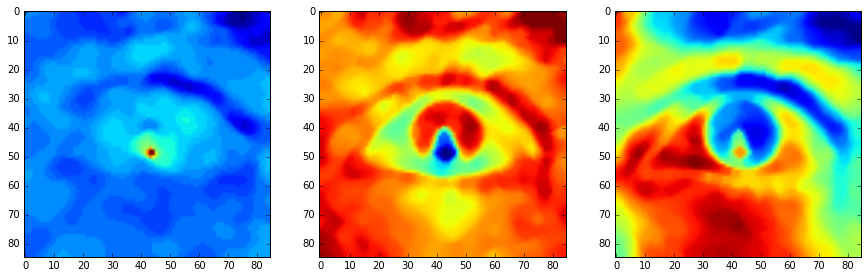

In [14]:
img = eyelist[0].copy()
blur = cv2.GaussianBlur(img,(5,5),0)
#blur = cv2.bilateralFilter(img,9,75,75)
hsv = cv2.cvtColor(blur, cv2.COLOR_BGR2HSV)
hsv = cv2.medianBlur(hsv, 5)
print(hsv[:, :, 0].min(), hsv[:, :, 0].max(), hsv[30, 30, 0], hsv[10, 10, 0])
fig = plt.figure(figsize=(15, 5))
for i in range (3): 
    ax = fig.add_subplot(1, 3, i+1)
    ax.imshow(hsv[:, :, i])
    #plt.imshow(cv2.medianBlur(hsv[:, :, i], 19))

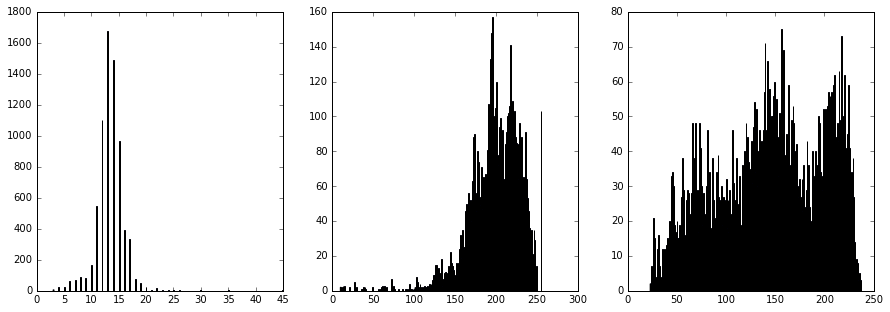

In [15]:
fig = plt.figure(figsize=(15, 5))
for i in range (3): 
    ax = fig.add_subplot(1, 3, i+1)
    ax.hist(hsv[:, :, i].ravel(),256)

### reflection aka glint

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in double_scalars


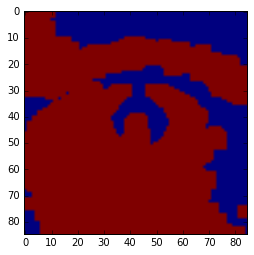

In [20]:
value = hsv[:, :, 2].copy()
value = cv2.GaussianBlur(value, (3, 3), 0)
hist = cv2.calcHist([gray], [0], eyebrow, [256], [0,256])
ret, reflection_mask = cv2.threshold(gray, otsu_thresh(hist), 255, cv2.THRESH_BINARY)
kernel = np.ones((5,5),np.uint8)
reflection_mask = cv2.dilate(reflection_mask, kernel, iterations = 1)
plt.imshow(reflection_mask)


In [ ]:
plt.imshow(skin_mask * (255 - reflection_mask))
plt.colorbar()

### skin mask

In [ ]:
ret_skin, skin_mask = cv2.threshold(hsv[:, :, 0], 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
skin_mask = (255 - skin_mask) * (eyebrow) * 255
plt.imshow(skin_mask)
plt.colorbar()

In [ ]:
image, contours, hierarchy = cv2.findContours(skin_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnt = contours[0]
M = cv2.moments(cnt)
print (M)
skin_mask = cv2.drawContours(skin_mask, contours, -1, (0,255,0), 3)
plt.imshow(skin_mask)


In [ ]:
ellipse = cv2.fitEllipse(cnt)
skin_mask = cv2.ellipse(skin_mask, ellipse,(0,255,0), 2)
(x,y),(MA,ma),angle = cv2.fitEllipse(cnt)
print((x,y),(MA,ma),angle)

In [ ]:
img = eyelist[0].copy()
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
fig = plt.figure(figsize=(15, 5))
for i in range (3): 
    ax = fig.add_subplot(1, 3, i+1)
    plt.imshow(hsv[:, :, i]*skin_mask)


In [ ]:
value = hsv[:, :, 2].copy()
hist = cv2.calcHist([value], [0], skin_mask * (255 - reflection_mask), [256], [0, 256])
ret, iris_mask = cv2.threshold(value, otsu_thresh(hist), 255, cv2.THRESH_BINARY)
iris_mask = cv2.bitwise_and(iris_mask, iris_mask, mask=skin_mask * (255 - reflection_mask))
plt.imshow(iris_mask)

In [ ]:
iris = iris_mask + skin_mask
iris = cv2.erode(iris, kernel, iterations = 1)
plt.imshow(iris)
plt.colorbar()

In [ ]:
image, contours, hierarchy = cv2.findContours(skin_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnt = contours[0]
M = cv2.moments(cnt)
(x,y),(MA,ma),angle = cv2.fitEllipse(cnt)
print((x,y),(MA,ma),angle)

## more methods

https://github.com/pupil-labs/pupil/blob/master/pupil_src/capture/pupil_detectors/canny_detector.py

or detect all contours, then apply a heuristic to catch the features / then use camshift to track them


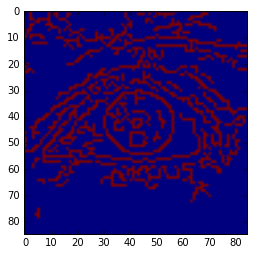

In [25]:
image = eyelist[0].copy()

#ret,thresh = cv2.threshold(img,127,255,0)
edges = cv2.Canny(image,100,200)
plt.imshow(edges)

1.0
{'mu12': 0.02222222222796222, 'mu02': 0.16666666666606034, 'mu30': -0.007407407407427513, 'nu30': -0.007407407407427513, 'nu03': 1.1641532182693481e-10, 'm21': 1681.1666666666667, 'm00': 1.0, 'nu02': 0.16666666666606034, 'mu11': 0.0, 'nu21': -1.1723955140041653e-13, 'mu03': 1.1641532182693481e-10, 'm12': 27669.466666666667, 'nu20': 0.05555555555556069, 'm20': 21.833333333333332, 'm01': 77.0, 'm03': 456571.5, 'nu11': 0.0, 'm02': 5929.166666666666, 'm11': 359.3333333333333, 'm30': 102.4, 'm10': 4.666666666666666, 'mu21': -1.1723955140041653e-13, 'mu20': 0.05555555555556069, 'nu12': 0.02222222222796222}
4.5
{'mu12': -4.191380887055004, 'mu02': 7.1512345679038845, 'mu30': -4.024645633529872, 'nu30': -0.09369067388779591, 'nu03': 0.0490503180345991, 'm21': 1326356.5166666666, 'm00': 4.5, 'nu02': 0.3531473860693276, 'mu11': -4.797839506169112, 'nu21': 0.11685867580884737, 'mu03': 2.1070416094735265, 'm12': 1344221.1833333333, 'nu20': 0.2854747751869267, 'm20': 19762.083333333332, 'm01': 

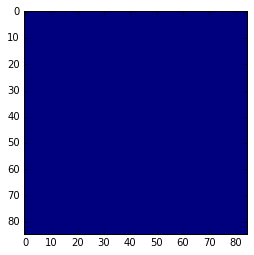

In [24]:
image_, contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    rect = cv2.boundingRect(cnt)
    #if rect[2] < 5 or rect[3] < 5: continue
    print (cv2.contourArea(cnt))
    M = cv2.moments(cnt)
    print (M)
    edges = cv2.drawContours(edges, contours, -1, (0,255,0), 3)
plt.imshow(edges)